In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

cuda:0


### Data Preparation

Let's first import all the datasets associated to the simulated curves. These correspond to random parameter initializations for Helena's BlaM model of growth. 

In [3]:
# Define the file path
file_path = 'data/my_curves10k.npy'

# Load in the data
X_raw  = np.load(file_path)

# Print out the shape of this data
print(X_raw.shape)

(10000, 3, 3, 145)


The structure of the dataset corresponds to 10,000 unique parameter combinations, each of which consists of three varibales which evolve over time: the species population $n$ in the first position, $b$ the Beta-lactamase enzyme concentration, and $a$ is the antibiotic concentration. We are only interested in embedding the growth dynamics, $n$ in the system. 

We have for each of these sets of parameters and three variables, we have three conditions corresponding to pure growth without any antibiotic, growth with antibiotic, and growth with antibiotic and Bla inhibitor. 

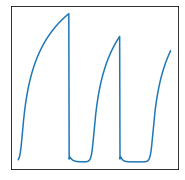

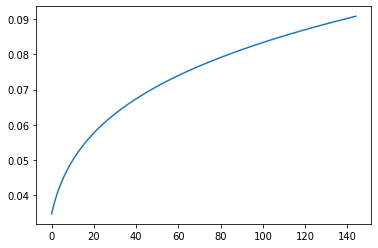

In [14]:
# Pull off only the cell population and concentanate into a single series. 
X = X_raw[:,:,0,:].reshape(10000,-1)

#fig, axs = plt.subplots(1,1,figsize = (3,3), sharex = True, sharey = True)

# for ax in axs.flatten():
#     ax.plot(X[np.random.randint(100),:].T, color = 'blue')
#     ax.set_xticks([])
#     ax.set_yticks([])

plt.figure(figsize = (3,3))
plt.xticks([])
plt.yticks([])
plt.plot(X[np.random.randint(100),:].T)
plt.show()

plt.plot(data[np.random.randint(100),:])

Let's now plot some of the dataset just to confirm what we are looking at. 

## VAE Compression

Next we'll treat VAE compression of these data using a simple convolutional encoder/decoder structure. We'll use a simple CNN encoder/decoder structure for generating our embeddings where we first apply convolutional operators to generate features and then linear layers to embed into the desired latent space. 

In [62]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    running_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        reconstruction, mean, logvar = model(data)
        recon_loss = criterion(reconstruction, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + alpha * kl_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)

            running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

We'll now break up the training and testing sets apart and load them into dataloader. While we're at it we'll also go ahead and define a hyperparameter dictionary to collect all hyperparameters of interest in a single location.

In [66]:
# Define the hyperparameters
batch_size = 1000
latent_dim = 20
alpha =  1e-6
lr= 1e-3
min_lr = 5e-6
epochs = 500
gamma = 0.99
weight_decay= 1e-4
seq_length = 145*3

In [67]:
#prepare data for training.
scaler = MinMaxScaler()

data = X
data_normalized =  scaler.fit_transform(data)

# Convert data into tensor
data_normalized = torch.tensor(data_normalized).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
data_normalized = data_normalized.unsqueeze(1)

# Split the data into train and test sets
train_data, test_data, train_indices, test_indices = train_test_split(data_normalized, range(data_normalized.shape[0]), test_size=0.2, random_state=42)

train_data = train_data.clone().detach().float()
test_data = test_data.clone().detach().float()

print(train_data.shape)

# Prepare DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

torch.Size([8000, 1, 435])


Now we'll define the actual training loop and execute it: 

In [68]:
# Model creation, loss function, and optimizer
model = VAE(latent_dim=latent_dim)
model = model.to(device)
print(f'The model has {count_parameters(model):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

# Training loop
train_loss_values = []
test_loss_values = []

# Initialize early stopping parameters
best_test_loss = np.inf  # Best test loss so far
epochs_no_improve = 0  # Counter for epochs since the test loss last improved
patience = 100 # Patience for early stopping

model

The model has 490,345 parameters


VAE(
  (encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): LeakyReLU(negative_slope=0.01)
    )
    (fc_mean): Linear(in_features=6960, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=6960, out_features=20, bias=True)
  )
  (decoder): CNNDecoder(
    (fc): Linear(in_features=20, out_features=6960, bias=True)
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.01)
      (1): ConvTranspose1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): LeakyReLU(negative_slope=0.01)
      (3): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,

In [53]:
from tqdm.notebook import trange

# implements a warmup schedule to start from a small learn rate. 
warmup_epochs = 8
def warmup_scheduler(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 1.0

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_scheduler)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


for epoch in trange(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, alpha)
    test_loss = test(model, test_loader, criterion)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    # Clamp minimum learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch < 10 else 100
    if (epoch + 1) % interval == 0:
        print('Epoch: {} Train: {:.7f}, Test: {:.7f}, Lr:{:.8f}'.format(epoch + 1, train_loss_values[epoch], test_loss_values[epoch], param_group['lr']))
    
    # Update learning rate
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0  # Reset the counter
    else:
        epochs_no_improve += 1  # Increment the counter

    if epochs_no_improve == patience:
        print('Early stopping!')
        break  # Exit the loop

# After training, get the latent variables
train_latent_vars = get_latent_variables(model, train_loader)
test_latent_vars = get_latent_variables(model, test_loader)    

NameError: name 'optimizer' is not defined

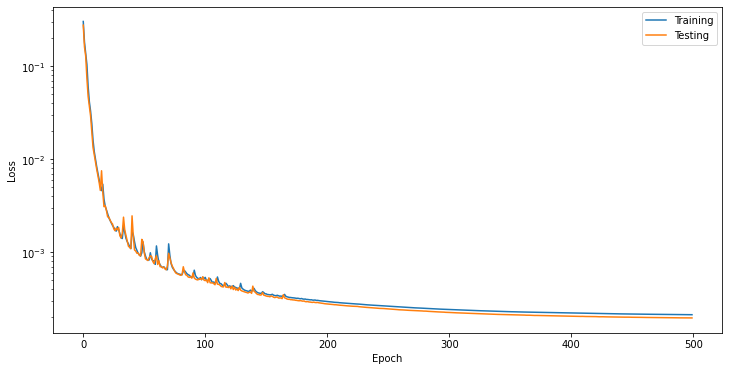

In [197]:
# Plotting the loss values
plt.figure(figsize=(12, 6))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

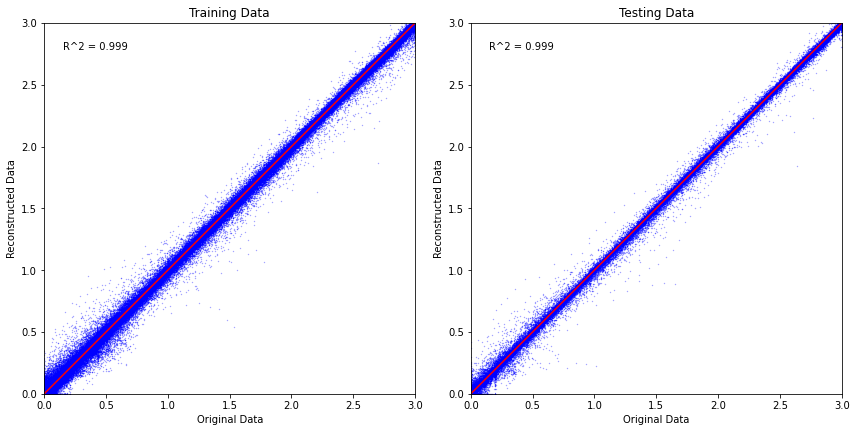

In [198]:
# Percentage of data to retrieve
percentage = 0.10
#scaler = scaler_data 
# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples].to(device)
subset_test_data = test_data[:num_test_samples].to(device)

with torch.no_grad():
    output_train, _, _ = model(subset_train_data)
    output_test, _, _ = model(subset_test_data)
    
#     output_train = output_train.cpu().numpy()
#     output_test = output_test.cpu().numpy()
    
# subset_train_data = subset_train_data.cpu().numpy()
# subset_test_data = subset_test_data.cpu().numpy()


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# # Scale the reconstructed data back to the range of the original data
output_train = scaler.inverse_transform(output_train.cpu().numpy())
output_test = scaler.inverse_transform(output_test.cpu().numpy())


# Scale the original data back to the original range
subset_train_data = scaler.inverse_transform(subset_train_data.cpu().numpy().squeeze(1))
subset_test_data = scaler.inverse_transform(subset_test_data.cpu().numpy().squeeze(1))

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'r')  # y=x line
axs[0].set_xlim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_ylim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original Data')
axs[0].set_ylabel('Reconstructed Data')
axs[0].set_title('Training Data')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'r')  # y=x line
axs[1].set_xlim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_ylim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original Data')
axs[1].set_ylabel('Reconstructed Data')
axs[1].set_title('Testing Data')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

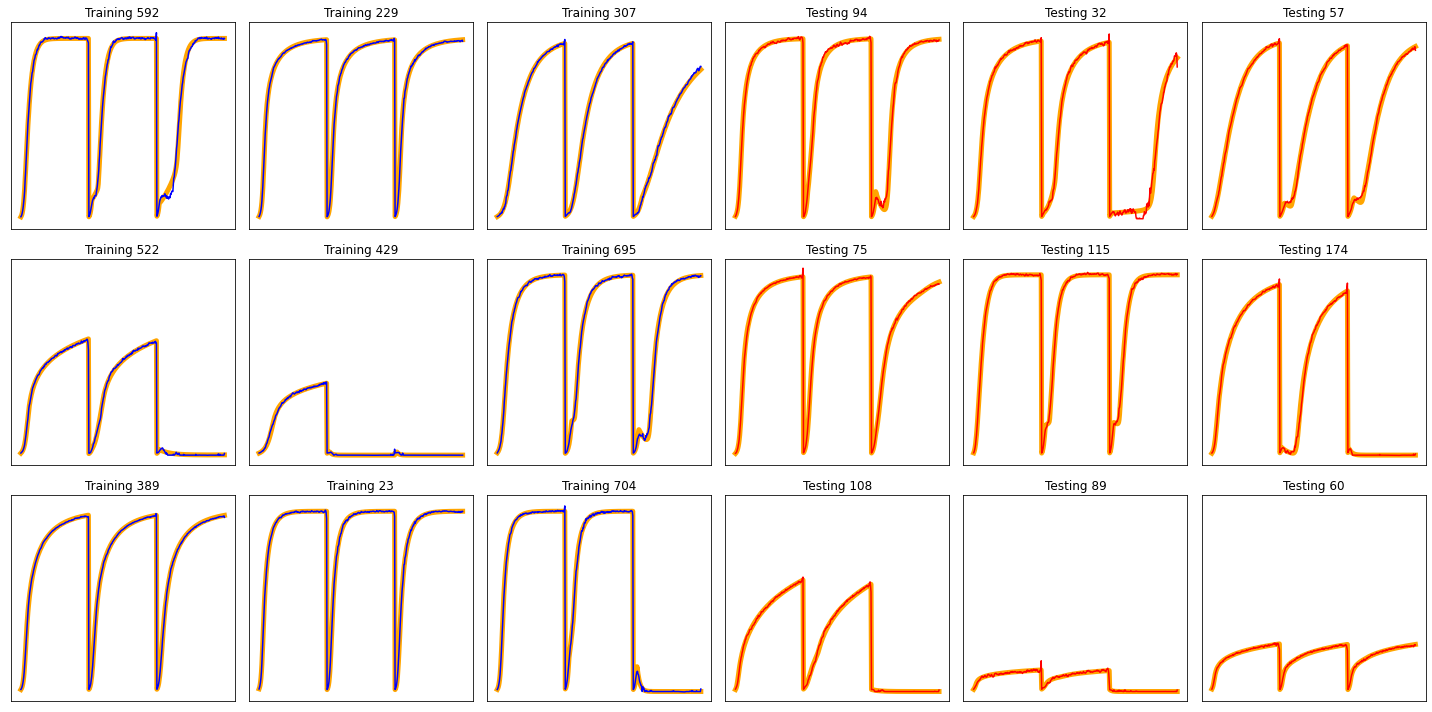

In [199]:
# Additional Panels for Sample Data Trajectories
N_fig = 3
fig, axs = plt.subplots(N_fig, 2*N_fig, figsize=(2*10,10), sharex = True, sharey = True)

# Training data trajectories
for i in range(N_fig):
    for k in range(N_fig):
        j = np.random.randint(0, subset_train_data.shape[0])
        axs[i,k].plot(subset_train_data[j].T, label='Original', color='orange', lw = 5)
        axs[i,k].plot(output_train[j].T, label='Reconstructed', color='blue')
        axs[i,k].set_title(f'Training {j + 1}')
        axs[i,k].set_xticks([])
        axs[i,k].set_yticks([])


# Testing data trajectories
for i in range(N_fig):
    for k in range(N_fig, 2*N_fig):
        j = np.random.randint(0, subset_test_data.shape[0])
        axs[i,k].plot(subset_test_data[j].T, label='Original', color='orange', lw = 5)
        axs[i,k].plot(output_test[j].T, label='Reconstructed', color='red')
        axs[i,k].set_title(f'Testing {j + 1}')
        axs[i,k].set_xticks([])
        axs[i,k].set_yticks([])

plt.tight_layout()
plt.savefig("./figures/test.png")
plt.show()


In [200]:
from sklearn.manifold import TSNE

# Compute t-SNE for train and test data
tsne = TSNE(n_components=2, random_state=0)
full_data_latent_vars_np = np.vstack([train_latent_vars_np,test_latent_vars_np ],)

tsne_data = tsne.fit_transform(full_data_latent_vars_np)
train_tsne = tsne_data[0:8000,:]
test_tsne = tsne_data[8000:,]

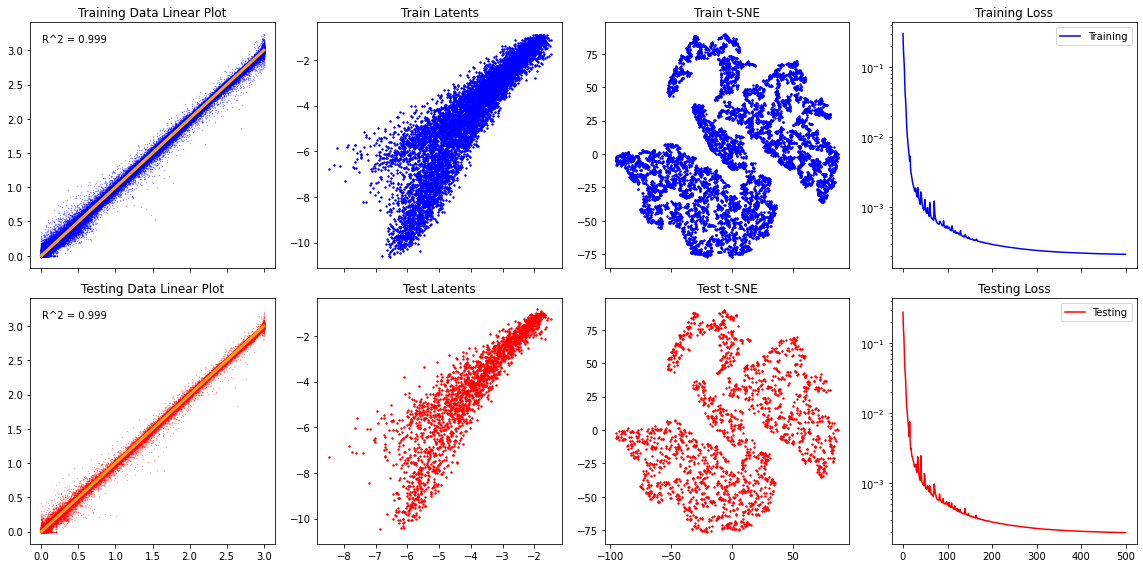

In [201]:
# Setup the 2x4 subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex='col', sharey='col')

# Training Data Linear Plot
axs[0][0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0][0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'orange', lw = 3)
axs[0][0].set_title('Training Data Linear Plot')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0][0].text(0.05, 0.95, f'R^2 = {r2_train:.3f}', transform=axs[0][0].transAxes, verticalalignment='top')

# Training Data First Two Latent Dimensions
axs[0][1].scatter(train_latent_vars_np[:,0], train_latent_vars_np[:,1], s=2.0, color='blue')
axs[0][1].set_title("Train Latents")

# Training Data t-SNE Projections
axs[0][2].scatter(train_tsne[:, 0], train_tsne[:, 1], s=2.0, color='blue')
axs[0][2].set_title("Train t-SNE")

# Training Loss
axs[0][3].semilogy(train_loss_values, label='Training', color='blue')
axs[0][3].set_title('Training Loss')
axs[0][3].legend()

# Testing Data Linear Plot
axs[1][0].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='red', alpha=0.5)
axs[1][0].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'orange', lw = 3)
axs[1][0].set_title('Testing Data Linear Plot')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1][0].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1][0].transAxes, verticalalignment='top')

# Testing Data First Two Latent Dimensions
axs[1][1].scatter(test_latent_vars_np[:,0], test_latent_vars_np[:,1], s=2.0, color='red')
axs[1][1].set_title("Test Latents")

# Testing Data t-SNE Projections
axs[1][2].scatter(test_tsne[:, 0], test_tsne[:, 1], s=2.0, color='red')
axs[1][2].set_title("Test t-SNE")

# Testing Loss
axs[1][3].semilogy(test_loss_values, label='Testing', color='red')
axs[1][3].set_title('Testing Loss')
axs[1][3].legend()

plt.tight_layout()
plt.savefig("./figures/test2.png")
plt.show()


## MLP Prediction

We will now need to use our trained VAE model to predict the true parameters for the system. 

In [69]:
# Load the ten parameters of the system
Y = np.load('./data/my_para10k.npy')

# 0 - 1 Normalize
label_scaler = MinMaxScaler()
Y = label_scaler.fit_transform(Y)

# Pull off the train/test sets
Y_train = Y[train_indices]
Y_test =  Y[test_indices ]

Let's now define an MLP to map from the trained encoder to the parameter space. 

In [70]:
class MLP(nn.Module):
    def __init__(self, initial_dim, hidden_dim, final_dim, depth):
        super(MLP, self).__init__()
        # List to hold all layers
        layers = []
        
        # Initial layer
        layers.append(nn.Linear(initial_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(depth - 1):  # Subtract 1 since the first layer is already added
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # Final layer
        layers.append(nn.Linear(hidden_dim, final_dim))
        
        # Create the network using nn.Sequential
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

Lastly, define a combined model which integrates both an MLP and decoder. 

In [71]:
class VAEMapper(nn.Module):
    def __init__(self, trained_vae_encoder, mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth):
        super(VAEMapper, self).__init__()
        
        # Freeze the parameters of the trained VAE encoder and put it in eval mode
        for param in trained_vae_encoder.parameters():
            param.requires_grad = False
        trained_vae_encoder.eval()
        
        self.vae_encoder = trained_vae_encoder
        self.mlp = MLP(mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth)
        
    def forward(self, x):
        latent_repr, _ = self.vae_encoder(x)  # We assume the VAE encoder returns (mu, logvar)
        return self.mlp(latent_repr)

Let's now define the hyperparameters of the system 

In [108]:
mlp_initial_dim = 30
mlp_hidden_dim  = 30
mlp_depth = 3
mlp_final_dim = Y.shape[1]

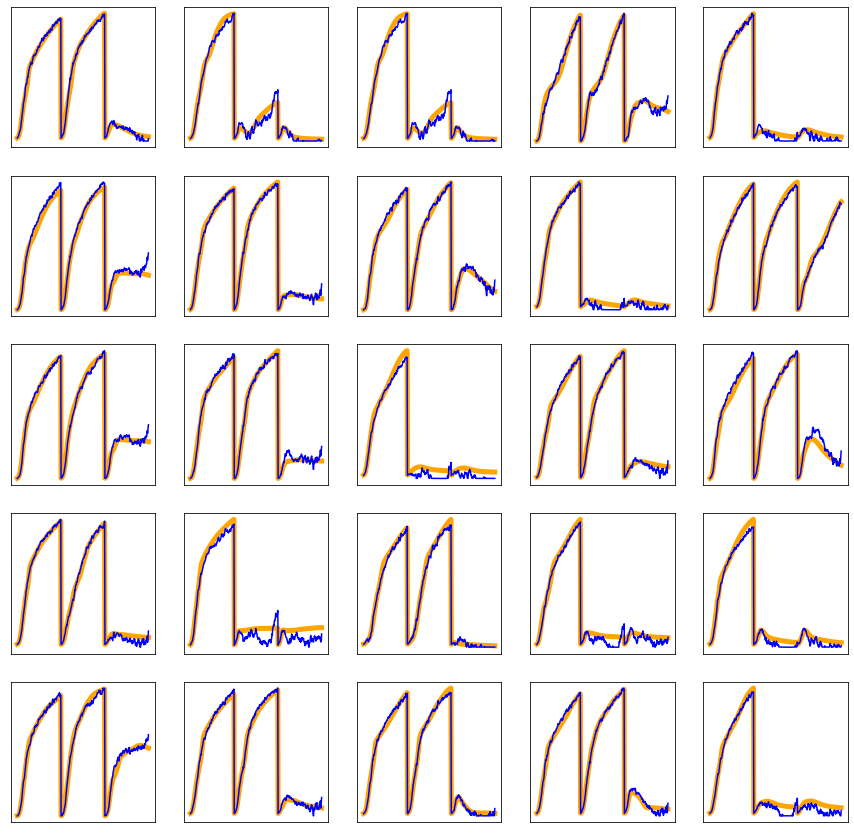

In [109]:
model = torch.load('./parameters/Initial_Batch/30_128_0.0001_vae.pth').to(device)
Z = np.load('./data/avg_OD_all_isolates.npy').reshape(311, -1)
Z_norm = scaler.transform(Z)

Z_recon, _, _ = model(torch.Tensor(Z_norm).unsqueeze(1).to(device))
Z_recon = scaler.inverse_transform(Z_recon.detach().cpu().numpy().squeeze())

fig, axs = plt.subplots(5,5, figsize = (15,15))

for ax in axs.flatten():
    j = np.random.randint(0,311)
    ax.plot(Z[j,:], color = 'orange', lw = 5)
    ax.plot(Z_recon[j,:], color = 'blue')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [110]:
# Lastly we define the model
mapper = VAEMapper(model.encoder, mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth).to(device)
mapper

VAEMapper(
  (vae_encoder): CNNEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): LeakyReLU(negative_slope=0.01)
    )
    (fc_mean): Linear(in_features=6960, out_features=30, bias=True)
    (fc_logvar): Linear(in_features=6960, out_features=30, bias=True)
  )
  (mlp): MLP(
    (net): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): ReLU()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): ReLU()
      (6): Linear(in_features=30, out_features=10, bias

Now we train the model. We define training parameters. 

In [111]:
lr= 1e-2
epochs = 1500

In [112]:
mapper = mapper.to(device)
print(f'The model has {count_parameters(mapper):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(mapper.mlp.parameters(), lr= lr,)

The model has 3,100 parameters


Let's now construct a dataloader:

In [113]:
from torch.utils.data import Dataset, DataLoader

class ParamSet(Dataset):
    def __init__(self, X_data, Y_data):
        self.X_data = torch.Tensor(X_data)
        self.Y_data = torch.Tensor(Y_data)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]

In [114]:
#Configure the datasets
train_params = ParamSet(train_data, Y_train)
test_params = ParamSet(test_data, Y_test)

train_loader = torch.utils.data.DataLoader(train_params, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_params, batch_size=batch_size, shuffle=False)

Now let's write the actual training loop: 

In [115]:
training_loss = []
testing_loss = []
for epoch in trange(epochs):
    
    # Put the model into training mode
    model.train()
    running_loss = 0.0
    
    # First compute the training loss
    for curves, labels in train_loader:

        curves = curves.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        pred = mapper(curves)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * curves.shape[0]
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_loss.append(epoch_loss)
    
        
    mapper.eval()
    running_loss = 0
    with torch.no_grad():
        for curves, labels in test_loader:
            curves = curves.to(device)
            labels = labels.to(device)
            
            pred = mapper(curves)
            loss = criterion(pred, labels)

            running_loss += loss.item() * curves.shape[0]
    
    epoch_loss = running_loss / len(test_loader.dataset)
    testing_loss.append(epoch_loss)
        
    
    if epoch % 50 == 0:
        print("Train: ", np.around(training_loss[epoch], 8) , "Test: ", np.around(testing_loss[epoch], 8) ) 

  0%|          | 0/1500 [00:00<?, ?it/s]

Train:  0.15451216 Test:  0.08436774
Train:  0.04234079 Test:  0.04219628
Train:  0.03982442 Test:  0.03998816
Train:  0.03863062 Test:  0.03907874
Train:  0.037871 Test:  0.03852637
Train:  0.03753145 Test:  0.03860795
Train:  0.03732147 Test:  0.03823552
Train:  0.03690929 Test:  0.03821849
Train:  0.03715814 Test:  0.03857177
Train:  0.03665862 Test:  0.03857222
Train:  0.03643455 Test:  0.03843085
Train:  0.03626526 Test:  0.03804716
Train:  0.03615693 Test:  0.03802842
Train:  0.03618933 Test:  0.03798116
Train:  0.03627939 Test:  0.0379815
Train:  0.03593328 Test:  0.03797175
Train:  0.03599411 Test:  0.03769987
Train:  0.03600059 Test:  0.03763796
Train:  0.03586731 Test:  0.03820179
Train:  0.03568529 Test:  0.03770542
Train:  0.03564951 Test:  0.0376673
Train:  0.03560014 Test:  0.03750436
Train:  0.03568458 Test:  0.03740026
Train:  0.03549061 Test:  0.03779417
Train:  0.03557094 Test:  0.03752557
Train:  0.03555345 Test:  0.03760718
Train:  0.0354229 Test:  0.03755778
Train:

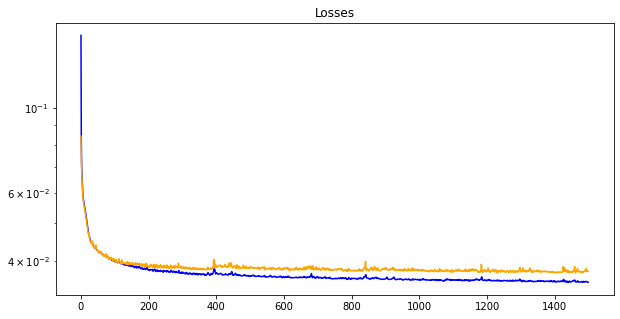

In [116]:
plt.figure(figsize = (10,5))
plt.title("Losses")
plt.semilogy(training_loss, label = 'Training', color = 'blue')
plt.semilogy(testing_loss,  label = 'Testing', color = 'orange' )
plt.show()

Let's now visualize the prediction performance: 

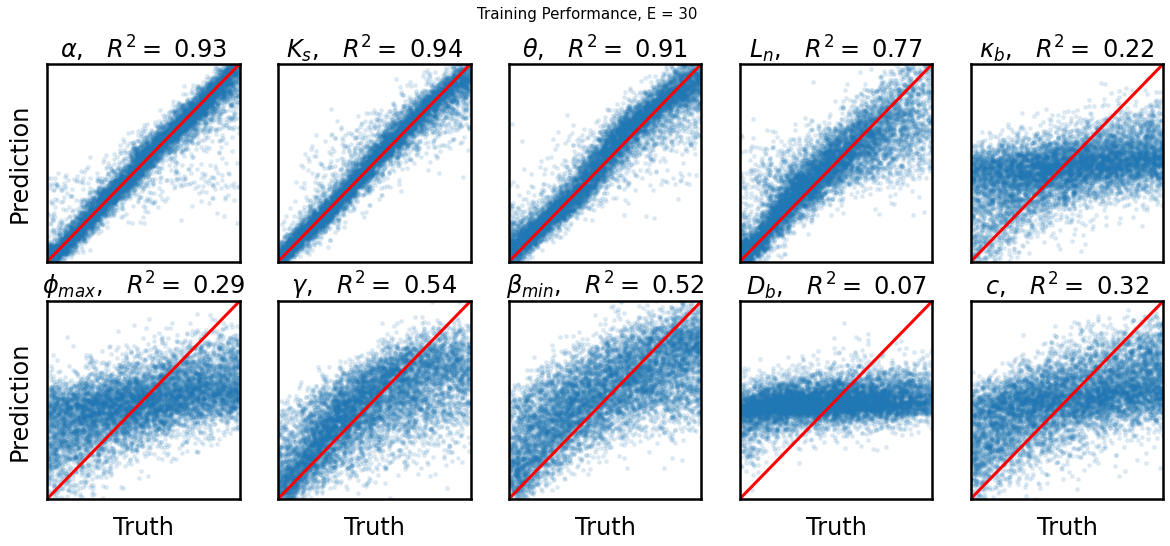

In [152]:
import seaborn as sns

sns.set_context("poster")
final_predictions = mapper(train_data.to(device)).cpu().detach().numpy()


fig, axs = plt.subplots(2,5, figsize = (20,8), sharex = True, sharey = True)
axs = axs.flatten()

titles = [r"$\alpha$", r"$K_s$", r"$\theta$", r"$L_n$", r"$\kappa_b$", r"$\phi_{max}$", r"$\gamma$", r"$\beta_{min}$", r"$D_b$", r"$c$"]
for i, ax in zip(range(10), axs):
    # Pull off a parameter
    param_label = Y_train[:,i].squeeze()
    param_predict = final_predictions[:,i].squeeze()
    
    r2 = r2_score(param_label, param_predict)
    
    
    ax.scatter(param_label, param_predict, alpha = 0.1, s = 10)
    ax.set_title(titles[i] + r",$ \quad R^2 = $" + f" {np.around(r2,2)}")
    if i == 0 or i == 5:
        ax.set_ylabel("Prediction")
    
    if i >= 5:
        ax.set_xlabel("Truth")
        
    ax.plot( [0, 1],[0, 1], color = 'red')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_xlim(0, param_label.max())
#     ax.set_ylim(param_predict.min(), param_predict.max())
plt.suptitle(f"Training Performance, E = {mlp_initial_dim}", fontsize = 15)
fig.patch.set_facecolor('white')
plt.show()

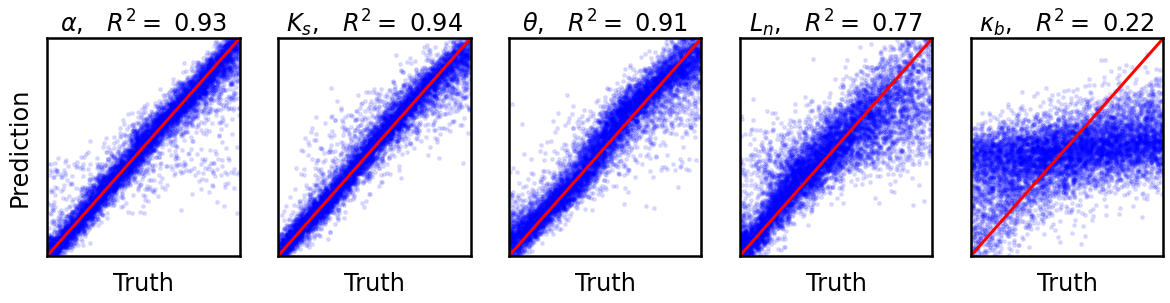

In [164]:
final_predictions = mapper(test_data.to(device)).cpu().detach().numpy()

fig, axs = plt.subplots(1,5, figsize = (20,4), sharex = True, sharey = True)
axs = axs.flatten()

for i, ax in zip(range(5), axs):
    # Pull off a parameter
    param_label = Y_train[:,i].squeeze()
    param_predict = final_predictions[:,i].squeeze()
    
    r2 = r2_score(param_label, param_predict)
    
    ax.scatter(param_label, param_predict, alpha = 0.1, s = 10, color = 'orange')
    ax.set_title(titles[i] + r",$ \quad R^2 = $" + f" {np.around(r2,2)}")
    if i == 0 or i == 5:
        ax.set_ylabel("Prediction")
    
    if i >= 0:
        ax.set_xlabel("Truth")
    
    ax.plot( [0, 1],[0, 1], color = 'red')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_xlim(0, param_label.max())
#     ax.set_ylim(param_predict.min(), param_predict.max())
#plt.suptitle(f"Testing Performance, E = {mlp_initial_dim}", fontsize = 15)
fig.patch.set_facecolor('white')
plt.show()

In [165]:
# # Save the model
# file_path = f"./models/my_{30}_mapper.pth"
# torch.save(mapper, file_path)

In [ ]:
label_